In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

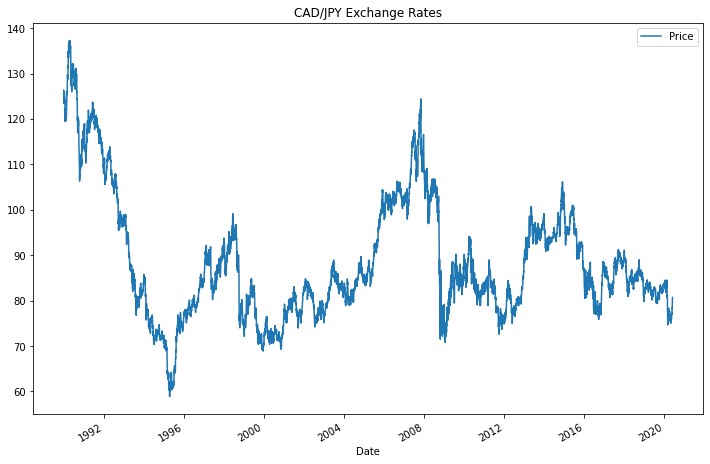

In [4]:
# Plot just the "Price" column from the dataframe:
title = 'CAD/JPY Exchange Rates'
cad_jpy_df['Price'].plot(figsize = (12,8), title = title, legend = True)
plt.show()

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** I can see a downward trend overall but in short terms it is oscillating and damping out the max i-e the next max is lower than the previous max but the min is getting some support after the year 2000.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
noise, trend = sm.tsa.filters.hpfilter(cad_jpy_df['Price'])

In [6]:
noise

Date
1990-01-02    0.519095
1990-01-03   -0.379684
1990-01-04   -2.048788
1990-01-05   -0.798304
1990-01-08   -0.897037
                ...   
2020-05-29   -0.503961
2020-06-01    0.218939
2020-06-02    1.088117
2020-06-03    1.125501
2020-06-04    0.872339
Name: Price_cycle, Length: 7929, dtype: float64

<AxesSubplot:xlabel='Date'>

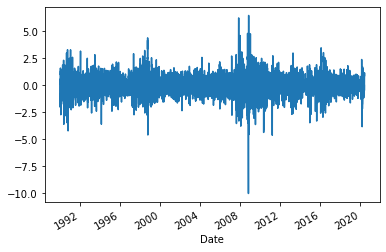

In [7]:
noise.plot()

<AxesSubplot:xlabel='Date'>

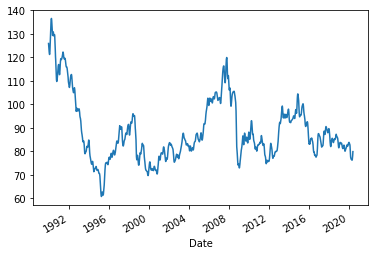

In [8]:
trend.plot()

In [9]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
df = pd.concat([cad_jpy_df['Price'], noise, trend], axis = 1)
df.rename(columns = {'Price_cycle': 'noise', 'Price_trend': 'trend'}, inplace = True)
df.head()

,Price,noise,trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7929 entries, 1990-01-02 to 2020-06-04
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   7929 non-null   float64
 1   noise   7929 non-null   float64
 2   trend   7929 non-null   float64
dtypes: float64(3)
memory usage: 247.8 KB


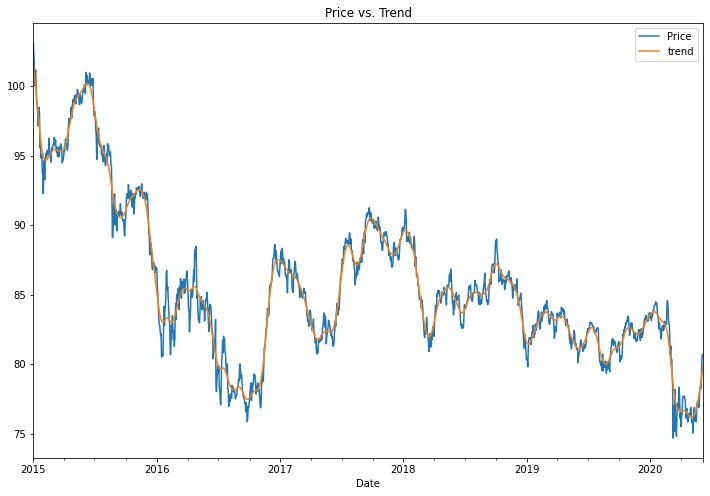

In [11]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
df.iloc[:,[0,2]].loc["2015-01-01":, :].plot(figsize = (12,8), title = 'Price vs. Trend', legend = True)
plt.show()

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** the overall trend is downward as seen in the previous trend analysis as well, but here we can see since 2015 onward the minimum is also getting lower than the previous one year by year.

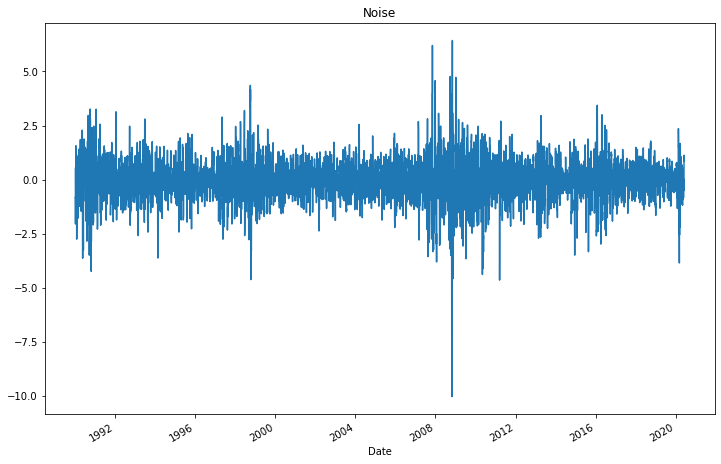

In [12]:
df['noise'].plot(figsize = (12,8), title = 'Noise')
plt.show()

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [13]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [23]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [24]:
# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARIMA(returns.values, order=(2,0,1))

# Fit the model and assign it to a variable called results
results = model.fit()

# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -9752.310
Date:                Sun, 01 May 2022   AIC                          19514.620
Time:                        16:50:11   BIC                          19549.511
Sample:                             0   HQIC                         19526.568
                               - 7928                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.237      0.813      -0.021       0.016
ar.L1         -0.0152      3.499     -0.004      0.997      -6.873       6.843
ar.L2         -0.0018      0.107     -0.017      0.987      -0.212       0.209
ma.L1         -0.0153      3.499     -0.004      0.997      -6.874       6.844
sigma2         0.6855      0.006    122.678      0.000       0.675       0.696
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11578.41
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

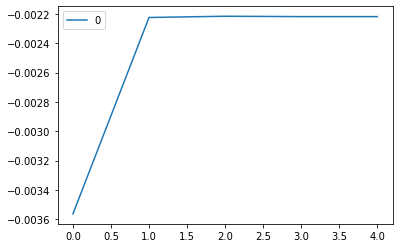

In [26]:
# Plot the 5 Day Returns Forecast
fc = results.forecast(5, alpha=0.05, )
pd.DataFrame(fc).plot()

**Question:** Based on the p-value, is the model a good fit?

**Answer:** the p values are very big and based on that we can ay that the model is not a good fit

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [27]:
from statsmodels.tsa.arima.model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
arima = ARIMA(returns.values, order=(5,1,1))
# Fit the model
results_arima = arima.fit()

In [28]:
# Output model summary results:
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -9754.288
Date:                Sun, 01 May 2022   AIC                          19522.577
Time:                        16:54:39   BIC                          19571.423
Sample:                             0   HQIC                         19539.304
                               - 7928                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0302      0.007     -4.357      0.000      -0.044      -0.017
ar.L2         -0.0026      0.007     -0.393      0.694      -0.016       0.010
ar.L3         -0.0102      0.008     -1.282      0.200      -0.026       0.005
ar.L4          0.0015      0.007      0.220      0.825      -0.012       0.015
ar.L5         -0.0188      0.007     -2.724      0.006      -0.032      -0.005
ma.L1         -1.0000      0.008   -121.043      0.000      -1.016      -0.984
sigma2         0.6849      0.009     80.181      0.000       0.668       0.702
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11612.88
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

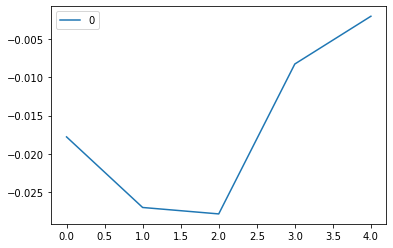

In [29]:
# Plot the 5 Day Returns Forecast
fc = results_arima.forecast(5, alpha=0.05, )
pd.DataFrame(fc).plot()

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** It seems like it will go up

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [32]:
import arch as arch
from arch import arch_model

In [35]:
# Estimate a GARCH model:
model_garch = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)
# Fit the model
res = model_garch.fit(disp="off")

In [36]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Sun, May 01 2022   Df Residuals:                     7928
Time:                        17:12:29   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [37]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [41]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = res.forecast(start=last_day, horizon=forecast_horizon)

In [42]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566029,12.573718,12.581301,12.588778,12.596153


In [43]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566029
h.2,12.573718
h.3,12.581301
h.4,12.588778
h.5,12.596153


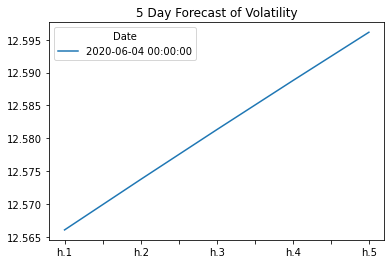

In [45]:
# Plot the final forecast
final.plot(title = '5 Day Forecast of Volatility')
plt.show()

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** Seems like volatility is increasing 

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * Based on time series analysis I would not buy Yen as the overall trend is downward and volatility is also increasing

2. Is the risk of the yen expected to increase or decrease?
    * Yes it is increasing

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * I can use GARCH for predicting volatility but I ARMA and ARIMA needs more fine tunning before we can see its true potential. But with the above parameters I would not feel confident using ARMA or ARIMA models